<a href="https://colab.research.google.com/github/DanishFaraaz/Deep-Learning-Projects/blob/main/23_Pytorch_Transfer_Learning_and_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() #interactive mode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2023-09-05 02:13:31--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.150.27, 54.192.150.31, 54.192.150.53, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.150.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  68.7MB/s    in 0.7s    

2023-09-05 02:13:33 (68.7 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_dat

**Setting up Data Transforms**

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])
    ])
}

**Setting up Data Loaders**

In [5]:
data_dir = './hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


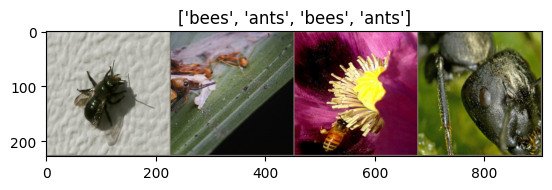

In [6]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std*inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = iter(dataloaders['train']).__next__()

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Create Function to train model**

In [13]:
from torch.utils.data import dataloader
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())  # to save the best model
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.4f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

**Create function to visualize model predictions**

In [8]:
def visualize_predictions(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return model.train(mode=was_training)

**Fine Tuning the CovNet**

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 275MB/s]


**Train and Evaluate**

In [14]:
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2229 Acc: 0.9139
val Loss: 0.1730 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4212 Acc: 0.8197
val Loss: 0.2044 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.2728 Acc: 0.8852
val Loss: 0.1749 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3038 Acc: 0.8566
val Loss: 0.1619 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3477 Acc: 0.8484
val Loss: 0.1666 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3858 Acc: 0.8197
val Loss: 0.2102 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.2703 Acc: 0.8934
val Loss: 0.1684 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2500 Acc: 0.8811
val Loss: 0.2058 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2894 Acc: 0.8648
val Loss: 0.1717 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3135 Acc: 0.8730
val Loss: 0.1725 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3469 Acc: 0.8648
val Loss: 0.1751 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2863 Acc: 0.8975
val Loss: 0.1990 Acc: 0.9346

Ep

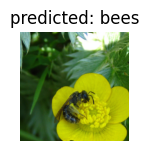

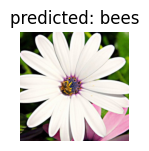

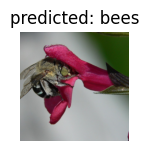

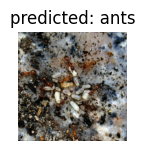

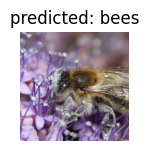

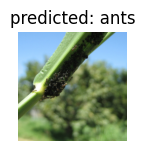

In [15]:
visualize_predictions(model_ft)

plt.ioff()
plt.show()

**Using CovNet as fixed feature extractor**

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Freezing the layers
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
model_ft = train_model(model_conv,
                       criterion,
                       optimizer_conv,
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7930 Acc: 0.6148


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


val Loss: 0.2017 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4621 Acc: 0.7582
val Loss: 0.1934 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4125 Acc: 0.8074
val Loss: 0.1896 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5214 Acc: 0.7787
val Loss: 0.2123 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4421 Acc: 0.7828
val Loss: 0.2336 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3578 Acc: 0.8525
val Loss: 0.1679 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5888 Acc: 0.7336
val Loss: 0.2946 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4472 Acc: 0.7951
val Loss: 0.2031 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4399 Acc: 0.7951
val Loss: 0.1670 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4219 Acc: 0.8402
val Loss: 0.2021 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3511 Acc: 0.8484
val Loss: 0.2270 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3939 Acc: 0.8607
val Loss: 0.2272 Acc: 0.9412

Epoch 12/24
----------
train Loss: 0.4039 Acc: 0.8320
v

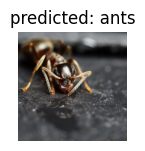

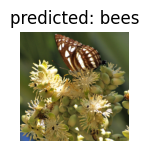

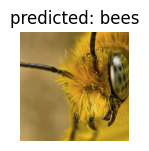

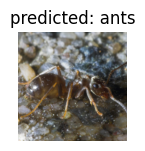

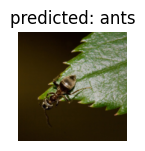

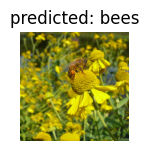

In [20]:
visualize_predictions(model_conv)

plt.ioff()
plt.show()